[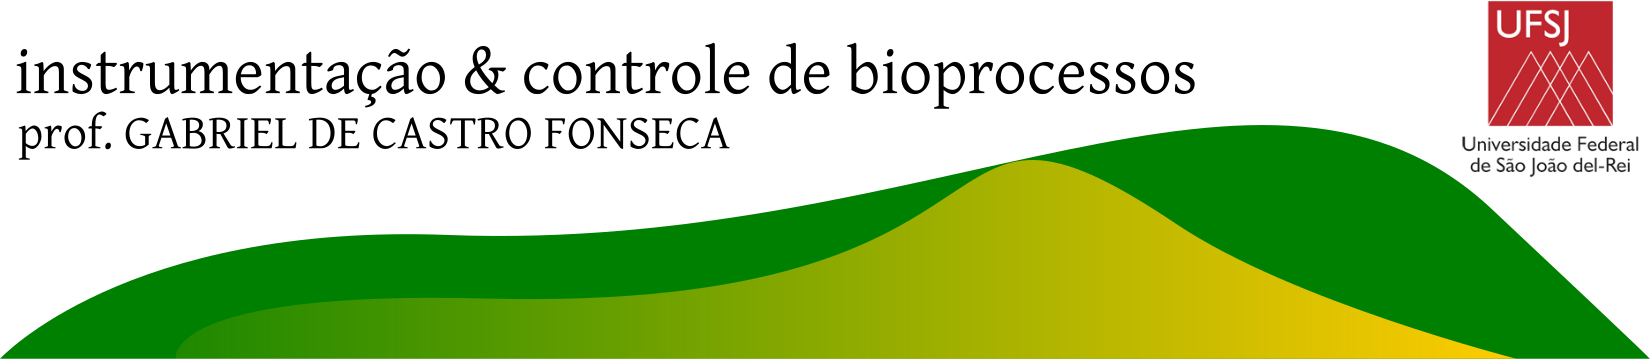](Aulas-Sumário.ipynb)

# Controle por Realimentação I

*Prof. Gabriel de Castro Fonseca (DQBIO/UFSJ)*<br>
*Instrumentação e Controle de Bioprocessos*

Este documento é publicado sob os termos da licença [GNU General Public Licence 3.0](https://www.gnu.org/licenses/gpl-3.0.en.html).

## Controle em malha fechada

Suponha que você quer preparar um bolo e leu na receita que ele deve ser assado a 180°C. Para controlar a temperatura de um forno típico, você só precisa girar um botão até a marquinha correta e acender a chama. O fabricante do forno provavelmente modelou o seu comportamento dinâmico ou fez testes empíricos para associar uma certa abertura da válvula que controla a vazão de gás que chega ao queimador (estímulo) com a temperatura atingida pelo forno em regime permanente (resposta). Esse tipo de controle de temperatura é chamado de **malha aberta**. 

A vantagem do controle em malha aberta é que ele é simples e barato, pois não exige nenhum instrumento de medida ou sistema de controle computadorizado. A desvantagem é que, como nenhuma medida é realizada para verificar se a temperatura no interior do forno é realmente a que você deseja, um forno desregulado pode levar a um bolo queimado.

Todos os sistemas que estudamos até a [aula passada](mimo.ipynb) podem ser considerados malha aberta: se você conhece o ganho do processo, pode introduzir um estímulo (variável manipulada) que leve a resposta do sistema até o valor que desejar. O problema é que se o ganho não for bem conhecido, a resposta do sistema pode não ser a esperada, e além disso estímulos indesejados (distúrbios ou perturbações) podem tirar a resposta do valor desejado com igual facilidade.

É para evitar esses problemas que existe o controle em **malha fechada**. Imagine que o forno do nosso exemplo é um modelo mais sofisticado onde a temperatura interna é medida continuamente e um sistema computadorizado regula automaticamente a vazão de gás de forma a levar a temperatura até o valor desejado. O sistema descrito é controlado em malha fechada, mais especificamente, controlado **por realimentação**.

A figura abaixo mostra um esquema de um sistema de controle por realimentação: o processo é constituído por pelo menos duas partes: uma influenciada pelo distúrbio $d(t)$ e outra influenciada pela variável manipulada $m(t)$, os dois tipos de de estímulos. O valor da variável resposta (variável controlada) $y(t)$ é medido e a sua leitura $y_m(t)$ é comparada ao valor desejado $y^*(t)$. A diferença entre esses dois valores é o erro $e(t)$, usado pelo controlador para calcular a intensidade da atuação $c(t)$ sobre o elemento final de controle, o que ajusta o valor da variável manipulada, "fechando" a malha de realimentação.

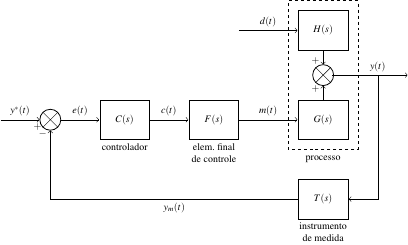

## Controle liga-desliga

O sistema de controle por realimentação mais simples e barato é o **liga-desliga (*on-off*)**, também conhecido como controle *bang-bang* ou controle com histerese. É o sistema de controle encontrado em geladeiras. Toda vez que a temperatura da geladeira aumenta até passar de um certo limite, um termostato manda um sinal para ligar o motor que inicia o ciclo de refrigeração. Quando a temperatura cai abaixo de outro limite, o termostato desliga o motor e o ciclo se repete.

Esse esquema está representado na Figura.

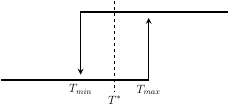

A ação de controle é $C(s)$ é uma constante não nula quando o sistema está ligado e vale zero quando o sistema está desligado. O balanço de energia em uma geladeira mantida fechada pode ser modelado como

$$
    m c_p \frac{dT}{dt} = UA(T_a-T) + \dot W
$$

* $mc_p = 40\rm\,kWh/K$ é a capacidade térmica da geladeira.
* $U A = 5\rm\,W/K$ é o produto entre a área da geladeira e o coeficiente de global de transferência de calor entre o interior da geladeira e o ar.
* $T_a = 26\rm\,^\circ C $ é a temperatura ambiente (distúrbio, $\delta T_a = d(t)$)
* $\dot W = -540\rm\,W$ é a potência da geladeira quando ligada (variável manipulada, $\delta \dot W = m(t)$).

Consideremos que inicialmente o interior da geladeira está à temperatura ambiente, após passar um longo período aberta. A temperatura desejada é $T^* = 6{\rm\,^\circ C} \;\; (y^* = 0)$. A temperatura da geladeira pode oscilar dentro de uma *banda morta* ou *histerese* de $\pm 2{\rm\,^\circ C}$ (entre $4$ e $8{\rm\,^\circ C}$). 

Vamos estudar seu comportamento dinâmico.

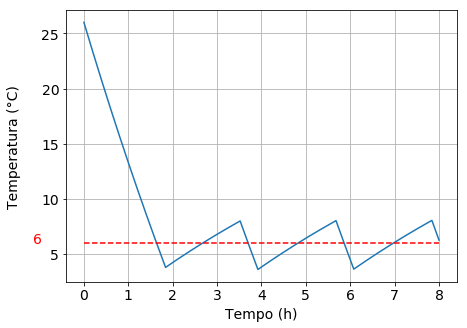

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def geladeira(tf,Tsp,To,n=201):
    """
    Modelo de geladeira.
    tf: tempo final de simulação.
    n : número de pontos.
    Retorna vetor de tempos e vetor de temperaturas.
    """
    # Parâmetros da geladeira
    mcp = 40
    UA = 5
    W = -540
    banda = 2
    ΔT = To - Tsp
        
    # Modelo matemático da geladeira
    def eqdif(T,t,c):
        return (-T + ΔT)*UA/mcp + W/mcp * c
    
    # controle on-off
    on, off = 1, 0
    c = 0
    
    # Tempo de integração
    Δt = tf/(n-1)
    tempo = np.linspace(0,tf,n)
    
    # Solução do problema
    T = np.zeros(n)
    T[0] = To - Tsp
    for i,t in enumerate(tempo[:-1]):
        
        if T[i] > banda: 
            c = on # liga quando temperatura ultrapassa limite máximo da banda
        if T[i] < -banda:
            c = off # desliga quando temperatura ultrapassa limite mínimo
       
        T[i+1] = odeint(eqdif,T[i],[t,t+Δt],args=(c,))[-1]
    
    return tempo, T + Tsp


# definição dos tempos
tf = 8
n = 201
t = np.linspace(0,tf,n)

# set-point
Ta = 26
Tsp = 6
x = np.ones(n)*Tsp

# solução do problema
t,T = geladeira(tf,Tsp,Ta)
plt.rcParams["figure.figsize"]=[7,5]
plt.rcParams.update({'font.size': 14})
plt.plot(t,T, t,x, 'r--')
plt.text(-1.15,Tsp,f"{Tsp}",color="red")
plt.xlabel("Tempo (h)")
plt.ylabel("Temperatura (°C)\n")
plt.grid()

Essa simulação também pode ser construída no Xcos seguindo-se o esquema da figura:

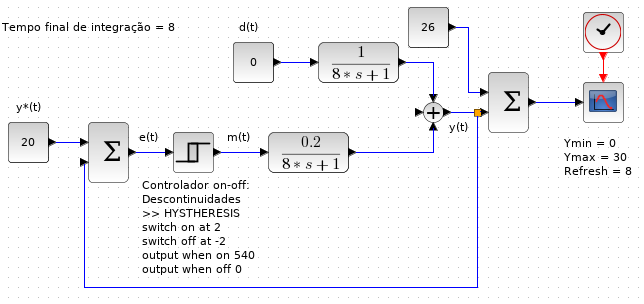

Sem o sistema de controle, a temperatura da geladeira permaneceria à temperatura ambiente, $26\rm\,^\circ C$. O sistema de controle mantém a temperatura próxima de $6\rm\,^\circ C$, mas a temperatura oscila permanentemente em torno do valor desejado. 

Essa oscilação poderia ser reduzida diminuindo-se o tamanho da banda morta ou não usando banda morta nenhuma, mas isso faria com que o elemento final de controle fosse acionado com frequência muito maior, provocando desgaste e reduzindo sua vida útil.

O controle liga-desliga é aceitável quando pode-se tolerar que a variável controlada oscile entre dois extremos e quando o sistema tem uma dinâmica relativamente lenta, o que evita acionamento excessivo do elemento final de controle.

## Controle PID

O controle liga-desliga é o sistema mais simples e barato, mas o controle PID é o mais utilizado.

No controle da temperatura de uma geladeira (liga-desliga) o elemento final de controle é um relê, isto é, um interruptor elétrico que tem apenas duas posições: ligado, no qual a atuação sobre o sistema é máxima; e desligado, no qual não há atuação.

O controle PID, por outro lado, está associado ou a uma válvula ou a uma bomba de vazão variável como elemento final de controle. Ao contrário do relê, esses EFC têm posições intermediárias e, por isso, a atuação sobre o sistema pode ser realizada de forma suave e contínua.

O nome PID é uma abreviação para **proporcional-integral-derivativo**, fazendo referência aos três termos utilizados no cálculo da ação de controle:

* o termo proporcional tem relação com o valor presente do erro;
* o termo integral tem relação com o valor passado do erro;
* o termo derivativo tem relação com o valor futuro previsto do erro.

Os termos integral e derivativo não são obrigatórios. Quando eles são omitidos, o controlador PID é chamado de **controle P** (apenas ação proporcional) ou **controle PI** (ações proporcional e integral). O **controle PD** é teoricamente possível, mas não tem muita aplicação prática.

Vamos estudar cada variação do controlador PID em ordem crescente de complexidade.

## Controle P

Uma das estratégias mais simples de controle consiste em aplicar uma ação de controle proporcional ao erro medido. No controle P a atuação do controlador é calculada pela fórmula

$$
    c(t) = K_c e(t) + b
$$

$b$ é o *bias* (viés, tendência) do controlador. O *bias* é a posição padrão em que a válvula é mantida quando o sistema está no estado desejado. Esse valor geralmente é um ponto intermediário de abertura da válvula e é definido quando o processo está sendo inicializado em modo de controle manual (isto é, com a válvula controlada por um operador humano). Quando o operador encontra o valor da variável manipulada que produz a resposta desejada, o controlador é passado para o modo automático (válvula acionada pelo controlador) e o valor do *bias* não muda. Quando existe controle integral (PI ou PID) o *bias* se torna desnecessário.

$K_c$ é o ganho do controlador e expressa uma relação linear entre o erro observado e a abertura ou fechamento da válvula. 

$$
    |K_c| = \frac{\Delta \%\text{ ação de controle}}{\Delta \% \text{ variável controlada}}
$$

Um $K_c = 2$ significa que uma variação de $1\%$ no valor da variável controlada provoca uma variação de $2\%$ na abertura da válvula. A porcentagem de variação da variável controlada está associada à faixa de operação do instrumento de medida. Por exemplo, suponha que um sensor é capaz de medir o nível de um tanque numa faixa entre zero e cinco metros. Se o nível do tanque varia em um metro com relação ao valor desejado, observamos uma variação de $\frac 1 5 \times 100 \% = 20\%$ na variável controlada. Para $K_c=2$, a abertura da válvula variaria em $40\%$. 

Em princípio, o ganho do controlador poderia ser positivo ou negativo dependendo de se um aumento no valor absoluto do erro precisar ser compensado com aumento no valor da variável manipulada (**ação direta**, $K_c < 0 $) ou com redução (**ação reversa**, $K_c > 0$). Na prática, porém, a maioria dos sistemas de controle sempre definem $K_c$ como positivo e o operador indica se o controlador é de ação direta ou reversa no momento da configuração do sistema. A escolha da ação de controle correta promove um ciclo de **realimentação negativa**, que corrige variações na variável controlada. Uma escolha equivocada promove realimentação positiva, amplificando erros e tornando o sistema instável.

Em alguns controladores antigos, o ganho do controlador $K_c$ é substituído por outro parâmetro chamado de *banda proporcional*, que é definida como

$$
    BP(\%) = \frac{100\%}{|K_c|}
$$

A banda proporcional equivale à variação na variável controlada que causaria um aumento de 0 a 100% na ação de controle. 

### Exemplo: Controle P em geladeira

Vamos revisitar a geladeira que descrevemos anteriormente, mas agora considerando que o controle liga-desliga seja trocado por controle proporcional.

Na forma padrão de representação de sistemas capacitivos, o modelo da geladeira pode ser reescrito como

\begin{gather*}
    8 \frac{dy}{dt} + y = d(t) + 0,2 m(t) \\
    y(t) = \underbrace{\frac{1}{8s+1}}_{H(s)} d(t) + \underbrace{\frac{0,2}{8s+1}}_{G(s)} m(t)
\end{gather*}

O sistema de controle altera o comportamento dinâmico do processo. O comportamento em malha fechada de realimentação seria:

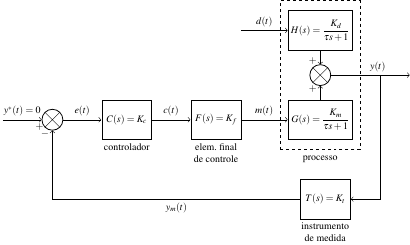

\begin{align*}
    y(t) &= H(s)d(t) + G(s)m(t) \\
    &\qquad m(t) = F(s) c(t) \\
    &\qquad c(t) = C(s) e(t) \\
    &\qquad e(t) = y^*(t) - y_m(t) \\
    &\qquad y_m(t) = T(s) y(t) \\
    y(t) &= H(s) d(t) + G(s) F(s) C(s) [y^*(t)- T(s) y(t)] 
\end{align*}
\begin{equation}
    \boxed{
        y(t) = \underbrace{\frac{H(s)}{1 + C(s)F(s)G(s)T(s)}}_{R(s)} d(t) + \underbrace{\frac{C(s)F(s)G(s)}{1 + C(s)F(s)G(s)T(s)}}_{S(s)} y^*(t)
    }
\end{equation}

Esta é a equação geral que descreve o comportamento dinâmico de qualquer processo controlado por realimentação. Observe que ela tem dois componentes: um que depende de distúrbios (**problema regulador**) e outro depende de mudanças no *set-point* (**problema servo**).

Para o caso particular analisado em nosso exemplo as funções de transferência associadas ao procesos são $G(s) = \frac{0,2}{8s+1}$ e $H(s) = \frac{1}{8s+1}$.

Idealmente, o instrumento de medida deve ser capaz de fazer uma leitura do valor da variável controlada muito rapidamente, ou seja, com atrasos de transferência ou de transporte desprezíveis. Isso significa que $T(s)\approx K_t$, ou seja, a função de transferência que relaciona a variável controlada e a sua medida deve ser uma constante.

O valor medido da variável controlada é convertido em um sinal analógico ou digital. Os sinais analógicos podem ser correntes elétricas com entre $4$ e $20\rm\,mA$ ou ar comprimido entre $3$ e $15\rm\,psi$. Sinais digitais são transmitidos na forma de um número inteiro. Por exemplo, um sinal transmitido como um número de $12\rm\,bit$ teria um valor entre $0000$ e $2^{12}-1=4095$.

Suponha que o valor mínimo que pode ser medido pelo termostato do refrigerador seja $-10\rm\,^\circ C$ e o valor máximo seja $40\rm\,^\circ C$. Uma temperatura de $15\rm\,^\circ C$ seria transmitida como uma corrente de $12\rm\,mA$, uma pressão de $9\rm\,psi$ ou como o número $2047$. O sistema de controle converte essas possíveis escalas para uma faixa de $0\%$ a $100\%$. No nosso caso, para uma faixa de temperaturas de $40-(-10) = 50\rm\,^\circ C$, $K_t = 2\%/\rm\,^\circ C$ e a temperatura de $15\rm\,^\circ C$ corresponde a uma medida de $50\rm\,%$.

Observe que o valor do *set-point* deve ser multiplicado pelo mesmo fator para ser comparado à medida da variável controlada ou ser expresso diretamente na forma de uma porcentagem.

A função de transferência do controlador proporcional é $C(s) = K_c$. Se desejarmos que a variável manipulada esteja no valor máximo quando o erro na temperatura for de $20\rm\,^\circ C$, nossa banda proporcional será $BP = \frac{20}{40-(-10)}\times 100\% = 40\%$. O ganho do controlador será, portanto, $|K_c |= \frac{100\%}{40\%} = 2,5$. O controlador no nosso caso é de ação direta, pois aumentos na temperatura do refrigerador (variável controlada) são respondidos com aumentos na potência fornecida (variável manipulada), portanto $K_c = -2,5$ computando-se o sinal.

Idealmente o elemento final de controle também deve ter uma dinâmica muito rápida, de forma que $F(s) \approx K_f$, ou seja, a função de transferência é uma constante. A potência mínima retirada pelo nosso refrigerador é $0\rm\,W$ quando a posição do EFC é $0\%$ e a máxima é $540\rm\,W$ quando a posição é $100\%$. Pode-se dizer que $K_f = 5,4 \rm\,W/\%$. 

Para podemos expressar o valor do *set-point* na mesma unidade que a variável controlada ($\rm^\circ C$) em vez de como uma porcentagem, é interessante considerar $K_t = 1$ e escrever $K_f$ não em termos de abertura da válvula, mas em termos da faixa de temperaturas medidas. 

$$
    K_f = \frac{\text{máximo}-\text{mínimo da variável manipulada}}{\text{máximo}-\text{mínimo do instrumento de medida}}
$$

Nesse caso, $K_f = \frac{540-0}{40-(-10)} = 10,8\rm\,W/^\circ C$. Observe que dá no mesmo usar $K_t = 2$ e $K_f = 5,4$ ou usar $K_t = 1$ e $K_f=10,8$, mas neste segundo caso nós podemos omitir completamente o parâmetro $K_t$. Os livros de controle costumam simplificar ainda mais o problema incorporando o ganho $K_f$ ao ganho do processo $K_m$. 

Substituindo-se todas as funções de transferência na equação geral da resposta em malha fechada,

\begin{gather*}
    y(t) = \frac{\frac{K_d}{\tau s + 1}}{1 + \frac{K_cK_fK_tK_m}{\tau s + 1}}d(t) + \frac{\frac{K_cK_fK_m}{\tau s + 1} }{1 + \frac{K_cK_fK_m}{\tau s + 1}}y^*(t)  \\
    y(t) = \frac{K_d}{\tau s + 1 + K_cK_fK_m} d(t) + \frac{K_cK_fK_m}{\tau s + 1 + K_cK_fK_m} y^*(t) \\
    y(t) = \frac{ \frac{K_d}{1+K_cK_fK_m} }{ \left( \frac{\tau}{1+K_cK_fK_m} \right) s + 1 } d(t) + \frac{ \frac{K_cK_fK_m}{1+K_cK_fK_m} }{ \left( \frac{\tau}{1+K_cK_fK_m} \right) s + 1 }y^*(t) \\
    y(t) = \frac{K_d^\prime}{\tau^\prime s + 1} d(t) + \frac{K_m^\prime}{\tau^\prime s + 1}y^*(t)
\end{gather*}

Observe que $K_d^\prime > 0$, por isso distúrbios sempre levam a resposta em malha fechada a um valor permanente diferente de zero (isto é, fora do valor desejado) e $K_m^\prime < 1$, de modo que mudanças no *set-point* levam a um valor permanente menor do que o desejado. A conclusão é que, por si só, o controle proporcional não é capaz nem de manter e nem de levar o sistema exatamente ao valor desejado.

Substituindo os valores numéricos (com exceção de $K_c$) teríamos

$$
    y(t) =  \frac{\frac{1}{1+2,16K_c}}{\frac{8}{1+2,16K_c} s + 1} d(t) + \frac{\frac{2,16K_c}{1+2,16K_c}}{\frac{8}{1+2,16K_c} s + 1} y^*(t)
$$

O nosso problema é do tipo servo, ou seja, há variação no valor desejado da temperatura, que passa de $26\rm\,^\circ C$ para $6\rm\,^\circ C$, ou seja, $y^*(t) = -20 \cdot \mathbf{1}^+(t)$. Como não há um distúrbio acontecendo simultaneamente (por exemplo, uma elevação na temperatura ambiente), $d(t) = 0$. Temos familiariadade suficiente com sistemas capacitivos para saber que a temperatura do refrigerador vai variar segundo a equação

\begin{gather*}
    y(t) = aK_m^\prime (1 - e^{-t/\tau^\prime}) \\
    y(t) = -20 \times \frac{2,16K_c}{1+2,16K_c} \times \left\{ 1 - \exp\left[ -\frac{(1+2,16 K_c)}{8} t \right] \right\}
\end{gather*}

In [6]:
from random import gauss
from scipy.optimize import fsolve
import ipywidgets as widgets

def geladeira_P(tf, d, sp, Kc, bias = 0, n = 201):
    """
    Modelo de geladeira com controle P.
    tf: tempo final de simulação.
    n : número de pontos.
    Retorna vetor de tempos e vetor de temperaturas.
    """
    # Parâmetros da geladeira
    mcp = 40
    UA = 5
    # Parâmetros do sistema capacitivo
    τ = mcp/UA
    Kd = 1
    Km = 1/UA
    Kf = 10.8
        
    # Modelo matemático da geladeira
    def eqdif(y,t,d,sp):
        e = sp - y # f é a integral do erro
        dy = ( -y + Kd*d + Km*Kf*(Kc*e + bias)) / τ 
        return dy
    
    t = np.linspace(0,tf,n)
    y = odeint(eqdif,0, t, args=(d,sp))
    ss = fsolve(eqdif,10,args=(0,d,sp))

    return t, y, ss

def principal(Kc):
    # definição dos tempos
    tf = 8
    n = 201

    # set-point
    Ta = 26
    Tsp = 6
    x = np.ones(n)*Tsp

    t,y, ss = geladeira_P(tf, 0, Tsp-Ta, Kc)
    y += Ta
    ss += Ta
    plt.rcParams["figure.figsize"]=[7,5]
    plt.rcParams.update({'font.size': 14})
    plt.plot(t,y, label="controle P")
    plt.text(3.4,17,f"temperatura final: {ss[0]:.2f} °C",backgroundcolor="white")
    plt.plot(t,T, label="controle on-off")
    plt.plot(t,x, 'r--')
    plt.xlabel("Tempo (h)")
    plt.ylabel("Temperatura (°C)\n")
    plt.grid()
    plt.legend(loc = 'upper right')

Kc_widget = widgets.FloatSlider(min=0, max=15, step=2.5, value=0, description = r'$K_c$')
w = widgets.interact(principal, Kc = Kc_widget)
w.widget.children[-1].layout.height = '500px'
display(w)

interactive(children=(FloatSlider(value=0.0, description='$K_c$', max=15.0, step=2.5), Output()), _dom_classes…

<function __main__.principal(Kc)>

Note que a temperatura do refrigerador não atinge exatamente o valor desejado ($6\rm\,^\circ C$) quando se utiliza o controle proporcional. A diferença entre o valor permanente da variável controlada e o valor desejado é chamada de **erro permanente** (ou ***offset***).

Quanto maior o valor do ganho proporcional, menor o erro permanente, isto é, mais próximos chegamos do valor desejado. Entretanto, não é possível se aumentar arbitrariamente o valor de $K_c$ pois isso torna o controlador muito sensível e qualquer ruído aleatório na medida pode tornar o sistema instável.

Para se alcançar o valor desejado da variável controlada usando-se o controle P é preciso se ajustar adequadamente o *bias* do controlador.

In [7]:
def principal(bias):
    Kc = 5
    # definição dos tempos
    tf = 8
    n = 201

    # set-point
    Ta = 26
    Tsp = 6
    x = np.ones(n)*Tsp

    t, y, ss = geladeira_P(tf, 0, Tsp-Ta, Kc, -bias) 
    y += Ta
    ss += Ta
    plt.rcParams["figure.figsize"]=[7,5]
    plt.rcParams.update({'font.size': 14})
    plt.title(f"$K_c$ = {Kc:.2f}")
    plt.plot(t,y, label="controle P")
    plt.text(3.4,17,f"temperatura final: {ss[0]:.2f} °C",backgroundcolor="white")
    plt.plot(t,T, label="controle on-off")
    plt.plot(t,x, 'r--')
    plt.xlabel("Tempo (h)")
    plt.ylabel("Temperatura (°C)\n")
    plt.grid()
    plt.legend(loc = 'upper right')

b_widget = widgets.FloatSlider(min=0, max=15, step=3, value=0, description = 'bias')
w = widgets.interact(principal, bias = b_widget)
w.widget.children[-1].layout.height = '500px'
display(w)

interactive(children=(FloatSlider(value=0.0, description='bias', max=15.0, step=3.0), Output()), _dom_classes=…

<function __main__.principal(bias)>

O *bias* do controlador é ajustado colocando-o em **modo manual**, isto é, desconectando-se o elemento final de controle do sistema de controle e manipulando-se a válvula manualmente com um operador humano. Após o erro permanente ser eliminado a válvula é reconectada ao sistema de controle e o sistema volta ao **modo automático**.

Evidentemente, a necessidade de se ajustar o *bias* manualmente é um problema. Qualquer distúrbio no sistema faz com que seja preciso reajustar o *bias* e isso exige um monitoramento constante do processo por operadores humanos. Vejamos o que aconteceria, por exemplo, se a temperatura ambiente aumentasse de repente de $26$ para $40\rm\,^\circ C$ após a temperatura no interior da geladeira ter se estabilizado próxima do valor desejado (nesse caso teríamos um problema do tipo regulador).

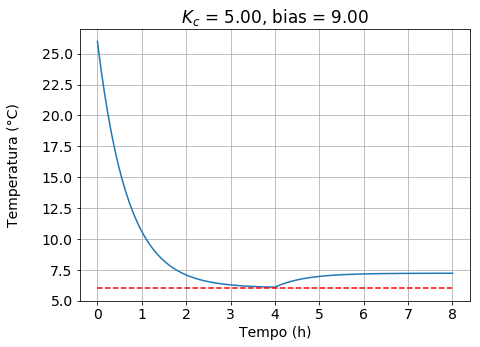

In [8]:
# definição dos tempos
tf = 8
n = 201

# set-point
Ta = 26
ΔT = 14
Tsp = 6
x = np.ones(n)*Tsp

# parâmetros do controlador
Kc = 5
bias = 9

t, y, ss = geladeira_P(tf, 0, Tsp - Ta, Kc, -bias) 
t1 = np.zeros(n)
#y1 = np.zeros(n)
_, y1, _ = geladeira_P(tf-4, ΔT, 0, Kc, 0, n = 101)
y[100:] = y[100:] + y1
y += Ta
ss += Ta
plt.rcParams["figure.figsize"]=[7,5]
plt.rcParams.update({'font.size': 14})
plt.title(f"$K_c$ = {Kc:.2f}, bias = {bias:.2f}")
plt.plot(t,y)
#plt.text(3.4,17,f"temperatura final: {ss[0]:.2f} °C",backgroundcolor="white")
plt.plot(t,x, 'r--')
plt.xlabel("Tempo (h)")
plt.ylabel("Temperatura (°C)\n")
plt.grid()

Após o distúrbio na temperatura ambiente a partir de $t = 4\rm\,h$, a abertura da válvula proporcionada pela resposta do controlador e pelo *bias* não seriam mais suficientes para manter a temperatura da geladeira no valor desejado. Seria necessário alterar de novo o valor do *bias* manualmente.

Uma alternativa mais interessante, como veremos [na próxima aula](pid2.ipynb) é utilizar um controlador proporcional-integral (PI), que dispensa o ajuste manual do *bias* para eliminar o erro permanente.

## Bibliografia

* C.A. Kluever (2018). Sistemas Dinâmicos: Modelagem, Simulação e Controle. LTC. Capítulo 10.
* B.W. Bequette. (2003). Process Control: Modeling, Design and Simulation. PHI Learning. Capítulo 5.
* C. Garcia (2017). Controle de Processos Industriais: Estratégias Convencionais. Volume 1, Blucher. Capítulo 7.
* C.A. Smith, A. Corripio (2008). Princípios e Prática do Controle Automático de Processo. 3 a ed. LTC. Capítulo 5.
* W.Y. Svrcek, D.P.Mahoney, B.R. Young (2014). A Real Time Approach to Process Control. 3ª ed. Wiley. Capítulo 4.
* M. King (2016). Process Control, a Practical Approach. 2ª ed. Wiley. Capítulo 3.
* J.C. Kantor (2019). [CBE 30338 Chemical Process Control](http://jckantor.github.io/CBE30338/). Capítulo 4.
* D. Cooper et al. (2019). [Practical Process Control](https://controlguru.com/table-of-contents/). Control Guru. Capítulos 6 e 7.